In [1]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
import LOUPE.WILLOW.loupe as lp
import tensorflow as tf
import h5py
import pandas as pd
import csv
import copy
import math
from utils.data_utils import temporal_indicator
from utils.data_utils import temporal_pooling
from utils.data_utils import export_vocabulary
import sys
import re
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


# Training Data

Load small training data set

In [2]:
def video_preprocess():
    # format
    train_data = pd.read_csv("train_extreme_small.csv")
    train_data.rename( columns={'Unnamed: 0':'index'}, inplace=True )
    train_data["duration"] = train_data["duration"].astype('float32')
    train_data["t_init"], train_data["t_end"] = train_data["timestamps"].str.split(", ", 1).str
    train_data["t_init"] = train_data["t_init"].str.strip("[")
    train_data["t_end"] = train_data["t_end"].str.strip("]")
    train_data["t_init"] = train_data["t_init"].astype('float32')
    train_data["t_end"] = train_data["t_end"].astype('float32')
    train_data = train_data.drop('timestamps', 1)

    # pool
    filename = "/home/songzeli/Data/sub_activitynet_v1-3.c3d.hdf5"
    video_feature_representation = h5py.File(filename, 'r')
    train_ids = train_data['id'].unique()
    f_inits = []
    f_ends = []
    max_pooled_representations = []
    max_proposals = 0
    padded_proposals = np.zeros((99,500,30))
    padded_framestamps = -1*np.ones((99,2,30))
    for v,video_id in enumerate(train_ids):
        #print("video id: ", video_id)
        temp = train_data[train_data['id']==video_id].reset_index()
        C3D_features = video_feature_representation["v_QOlSCBRmfWY"]['c3d_features'].value

        if max_proposals < temp.shape[0]:
            max_proposals = temp.shape[0]

        for i in range(temp.shape[0]):

            # get time info
            duration = temp["duration"][i]
            t_init = temp["t_init"][i]
            t_end = temp["t_end"][i]
            num_frames = C3D_features.shape[0]

            # compute start and end frame
            f_init = int(round((t_init/duration)*num_frames))
            f_end = int(round((t_end/duration)*num_frames))
            #print("f_init: ", f_init, "t_init: ", t_init)
            #print("f_end: ", f_end, "t_end: ", t_end)

            # get max pool
            if f_init <= f_end:
                max_pooled_rep = temporal_pooling(C3D_features[f_init:f_end],"max")
            else:
                max_pooled_rep = temporal_pooling(C3D_features[f_end:f_init],"max")

            # append info
            f_inits.append(f_init)
            f_ends.append(f_end)
            max_pooled_representations.append(max_pooled_rep)
            padded_proposals[v,:,i] = max_pooled_rep
            padded_framestamps[v,0,i] = f_init
            padded_framestamps[v,1,i] = f_end


    f_inits = np.array(f_inits)
    f_inits = pd.DataFrame({'f_init': f_inits})
    f_ends = np.array(f_ends) 
    f_ends = pd.DataFrame({'f_end': f_ends})

    max_pooled_representations = np.array(max_pooled_representations)
    C3D_feature_column_names = ["h" + str(i) for i in range(max_pooled_representations.shape[1])] 
    max_pooled_representations = pd.DataFrame(max_pooled_representations, columns=C3D_feature_column_names)

    train_data = pd.concat([train_data, f_inits, f_ends, max_pooled_representations], axis=1)
    train_data.to_pickle("train_data")

    print("number of examples: ", train_ids.shape[0])
    print("train_data.shape: ", train_data.shape)
    print("padded_proposals.shape: ", padded_proposals.shape)
    print("padded_framestamps.shape: ", padded_framestamps.shape) 
    return train_ids,train_data,padded_proposals,padded_framestamps
    
train_ids,train_data,padded_proposals,padded_framestamps = video_preprocess()   

number of examples:  99
train_data.shape:  (590, 508)
padded_proposals.shape:  (99, 500, 30)
padded_framestamps.shape:  (99, 2, 30)


# Get word2id in sentences

In [3]:
_PAD = b"<pad>"
_UNK = b"<unk>"
_STA = b"<sta>"
_END = b"<end>"
_START_VOCAB = [_PAD,_UNK,_STA,_END]
PAD_ID = 0
UNK_ID = 1
STA_ID = 2
END_ID = 3

def caption_preprocess():

    
    train_voc = pd.read_csv("train_all.csv")
    train_voc.rename( columns={'Unnamed: 0':'index'}, inplace=True )
    train_voc["duration"] = train_voc["duration"].astype('float32')
    train_voc["t_init"], train_voc["t_end"] = train_voc["timestamps"].str.split(", ", 1).str
    train_voc["t_init"] = train_voc["t_init"].str.strip("[")
    train_voc["t_end"] = train_voc["t_end"].str.strip("]")
    train_voc["t_init"] = train_voc["t_init"].astype('float32')
    train_voc["t_end"] = train_voc["t_end"].astype('float32')
    train_voc = train_voc.drop('timestamps', 1)

    export_vocabulary(train_voc)
    df = pd.read_csv('vocabulary.csv')
    voc = df["Unnamed: 0"].tolist()
    vocabulary = []
    for word in voc:
        if word.isalpha():
            vocabulary.append(word)
            
    vocab_size = len(vocabulary)
    return vocabulary,vocab_size
    

def get_wordvector(emb_dim,vocab_size,vocabulary):
    """Reads from original word lib file and returns embedding matrix and
    mappings from words to word ids.

    Returns:
      emb_matrix: Numpy array shape (len(vocabulary), word_dim) containing word embeddings
        (plus PAD and UNK embeddings in first 4 rows).
        The rows of emb_matrix correspond to the word ids given in word2id and id2word
      word2id: dictionary mapping word (string) to word id (int)
      id2word: dictionary mapping word id (int) to word (string)
    """
    
    vocabulary = _START_VOCAB + vocabulary

    emb_matrix = np.zeros((vocab_size + len(_START_VOCAB), emb_dim))
    word2id = {}
    id2word = {}

    random_init = True
    # randomly initialize all the tokens
    emb_matrix[:, :] = np.random.randn(vocab_size + len(_START_VOCAB), emb_dim)

    # put start tokens in the dictionaries
    idx = 0
    for word in vocabulary:
        word2id[word] = idx
        id2word[idx] = word
        idx += 1


    final_vocab_size = vocab_size + len(_START_VOCAB)
    assert len(word2id) == final_vocab_size
    assert len(id2word) == final_vocab_size
    assert idx == final_vocab_size

    return emb_matrix, word2id, id2word
#Changed by Songze
def split_by_whitespace(sentence):
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(re.split(" ", space_separated_fragment))
    return [w for w in words if w]


def intstr_to_intlist(string):
    """Given a string e.g. '311 9 1334 635 6192 56 639', returns as a list of integers"""
    return [int(s) for s in string.split()]


def sentence_to_token_ids(sentence, word2id):
    """Turns an already-tokenized sentence string into word indices
    e.g. "i do n't know" -> [9, 32, 16, 96]
    Note any token that isn't in the word2id mapping gets mapped to the id for UNK
    """
    tokens = split_by_whitespace(sentence) # list of strings
    ids = [word2id.get(w.lower(), UNK_ID) for w in tokens]
    return tokens, ids


def padded(token_batch, batch_pad=0):
    """
    Inputs:
      token_batch: List (length batch size) of lists of ints.
      batch_pad: Int. Length to pad to. If 0, pad to maximum length sequence in token_batch.
    Returns:
      List (length batch_size) of padded lists of ints.
        All are same length - batch_pad if batch_pad!=0, otherwise the maximum length in token_batch
    """
    maxlen = max(lambda x: len(x), token_batch) if batch_pad == 0 else batch_pad
    res = [STA_ID]+token_batch+[END_ID]+[PAD_ID] * (maxlen - len(token_batch)-2)

    return res

def get_padded_sentences_id(pad_len,train_ids):
    all_padded_sentences = np.zeros((99,pad_len,30))
    for v,video_id in enumerate(train_ids):
        temp = train_data[train_data['id']==video_id].reset_index()
        for i in range(temp.shape[0]):
            words,ids = sentence_to_token_ids(temp['sentences'][i][:-1],word2id)
            ids_pad = padded(ids,pad_len)
            all_padded_sentences[v,:,i] = ids_pad


    all_padded_sentences_2 = np.zeros((99,pad_len+1,30))
    for v,video_id in enumerate(train_ids):
        temp = train_data[train_data['id']==video_id].reset_index()
        for i in range(temp.shape[0]):
            words,ids = sentence_to_token_ids(temp['sentences'][i][:-1],word2id)
            ids_pad = padded(ids,pad_len+1)
            all_padded_sentences_2[v,:,i] = ids_pad
    all_padded_sentences_id = np.array(all_padded_sentences).astype(int)
            
    return all_padded_sentences,all_padded_sentences_2,all_padded_sentences_id


In [4]:
embedding_size =512
vocabulary,vocab_size = caption_preprocess()
emb_matrix,word2id,id2word = get_wordvector(embedding_size,vocab_size,vocabulary)
pad_len = 50
all_padded_sentences,all_padded_sentences_2,all_padded_sentences_id = get_padded_sentences_id(pad_len,train_ids)     
print("all_padded_sentences_2.shape: ", all_padded_sentences_2.shape)

Total number of words in all captions:  504895
Vocabulary Size (Unique):  13001
all_padded_sentences_2.shape:  (99, 51, 30)


In [5]:
def attention_module(H, Ipast, Ifuture, num_proposals, num_c3d_features, num_steps, batch_size,eps = 1e-10):
    """
    Implements the attention module: see https://cs.stanford.edu/people/ranjaykrishna/densevid/
    
    Arguments:
    H -- input dataset placeholder, of shape = [None, N, K] and dtype "float"
    Ipast -- placeholder for the indicators of past, shape = [None, K, K] and dtype "float"
    Ifuture == placeholder for the indicators of future, shape = [None, K, K] and dtype "float"
    parameters -- python dictionary containing your parameters "Wa", "ba", sapes [N,N] and [N,1] respectively

    Returns:
    Hout -- concatenated output (hpast, h, hfuture), shape = [batch_size, 3*num_c3d_features, num_proposals]
    """

    print("H dtype: ", H.dtype)
    print("Ipast dtype: ", Ipast.dtype)
    print("Ifuture dtype: ", Ifuture.dtype)
    #print("x dtype: ", x.dtype)
    #print("y dtype: ", y.dtype)
    
    # Retrieve the parameters from the dictionary "parameters" 
    Wa = tf.get_variable("Wa", [num_c3d_features,num_c3d_features], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    ba = tf.get_variable("ba", [num_c3d_features,1], initializer = tf.zeros_initializer())

    # forward pass
    W = tf.transpose(tf.tensordot(Wa,tf.transpose(H,perm=[1,2,0]),axes=[[1], [0]]),perm=[2,0,1]) + ba # shape: [None,num_proposals,num_proposals]
    A = tf.matmul(tf.transpose(W,perm=[0,2,1]),H) # shape: [None,num_proposals,num_proposals]
    A_flat = tf.reshape(A, [-1, num_proposals*num_proposals]) # shape: [None,num_proposals*num_proposals]

    # future features
    Ifuture_flat = tf.reshape(Ifuture, [-1, num_proposals*num_proposals]) # shape: [None,K*K]
    Afuture = tf.reshape(tf.multiply(Ifuture_flat,A_flat),[-1,num_proposals,num_proposals]) # shape: [None,K,K]
    Zfuture = tf.reduce_sum(Ifuture,axis=2)+eps # shape: [None,num_proposals]
    Hfuture = tf.transpose(tf.transpose(tf.matmul(H,tf.transpose(Afuture,perm=[0,2,1])),perm=[1,0,2])/Zfuture,perm=[1,0,2]) # shape: [None,num_c3d_features,num_proposals]

    # past features
    Ipast_flat = tf.reshape(Ipast, [-1, num_proposals*num_proposals]) # shape: [None,num_proposals*num_proposals]
    Apast = tf.reshape(tf.multiply(Ipast_flat,A_flat),[-1,num_proposals,num_proposals]) # shape: [None,num_proposals,num_proposals]
    Zpast = tf.reduce_sum(Ipast,axis=2)+eps # shape: [None,num_proposals]
    Hpast = tf.transpose(tf.transpose(tf.matmul(H,tf.transpose(Apast,perm=[0,2,1])),perm=[1,0,2])/Zfuture,perm=[1,0,2]) # shape: [None,num_c3d_features,num_proposals]

    # stacked features
    Hout = tf.concat([Hpast, H, Hfuture], 1)

    print("Hfuture shape: ", Hfuture.get_shape().as_list())
    print("W shape: ", W.get_shape().as_list())
    print("A shape: ", A.get_shape().as_list())
    print("A_flat shape: ", A_flat.get_shape().as_list())
    print("Ifuture_flat shape: ", Ifuture_flat.get_shape().as_list())
    print("Zfuture: ", Zfuture.get_shape().as_list())
    print("Hfuture: ", Hfuture.get_shape().as_list())
    print("Hpast: ", Hfuture.get_shape().as_list())
    print("Hout: ", Hout.get_shape().as_list())
    
    return Hout

def language_module(Hout, x, num_classes, hidden_dim, num_steps, num_proposals, num_layers, batch_size):
    '''
    Inputs: 
      number of classes
      hidden_dim = number units in lstm and word embedding
      num_steps, length of captions
      num_steps
      num_layers 
      batch_size
    '''
    
    Hout = tf.transpose(Hout, perm=[0,2,1])
    Hout = tf.reshape(Hout, [-1, 1500])
    
    # create placeholder
    #x_captions = tf.placeholder(tf.int32, [batch_size, num_proposals, num_steps], name="x_captions")
    
    
    feature_inputs = tf.expand_dims(tf.layers.dense(inputs=Hout,units=hidden_dim,activation=tf.nn.relu),1)
    print("feature_inputs.shape: ",feature_inputs.get_shape().as_list())

    embeddings = tf.get_variable('embedding_matrix', [num_classes, hidden_dim])
    embedding_inputs = tf.nn.embedding_lookup(embeddings, tf.reshape(x,[-1,num_steps]))
    print("embedding_inputs.shape: ",embedding_inputs.get_shape().as_list())
                                              
    lstm_inputs = tf.concat(values=[feature_inputs, embedding_inputs],axis=1)
    print("all_inputs.shape: ", lstm_inputs.get_shape().as_list())                                      
    
    lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden_dim,state_is_tuple=True)
    lstm_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * num_layers, state_is_tuple=True)
    initial_state = lstm_cells.zero_state(batch_size*num_proposals, tf.float32)
    lstm_outputs, final_state = tf.nn.dynamic_rnn(cell=lstm_cells,inputs=lstm_inputs,initial_state=initial_state)
    print("lstm_outputs.shape: ", lstm_outputs.get_shape().as_list())                                         
                                              
    logits = tf.layers.dense(inputs=tf.reshape(lstm_outputs,[-1,hidden_dim]),units=num_classes)
                                         
    predictions = tf.argmax(logits,1)
    predictions = tf.reshape(predictions, [batch_size,num_proposals,num_steps+1])
    print("predictions.shape: ", predictions.get_shape().as_list())
    
    logits = tf.reshape(logits, [batch_size,num_proposals,num_steps+1,num_classes])
    print("logits.shape: ", logits.get_shape().as_list())
                                                                            
    return predictions, logits

def caption_cost(y, logits, num_classes, num_proposals,num_steps,batch_size):
    print("y_captions.shape: ", y.get_shape().as_list())
    print()
    loss = tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=tf.reshape(logits,[-1,num_classes]), 
            labels=tf.reshape(y,[-1])
        )
    )
    return loss

# Check Forward Pass

# Modules

In [6]:
H_train = padded_proposals.astype(np.float32)
framestamps = padded_framestamps
Ipast = temporal_indicator(framestamps, mode="past")
Ipast_train = Ipast.astype(np.float32)
Ifuture = temporal_indicator(framestamps, mode="future")
Ifuture_train = Ifuture.astype(np.float32)
emb_matrix, word2id, id2word = get_wordvector(embedding_size,vocab_size,vocabulary) #changed by Songze
sentence_ids = all_padded_sentences_id
Ycaptions = copy.deepcopy(all_padded_sentences_2) # holds i
Xcaptions = copy.deepcopy(all_padded_sentences)
Xcaptions = Xcaptions.astype(np.int32)
Ycaptions = Ycaptions.astype(np.int32)
Xcaptions_train = np.transpose(Xcaptions,axes=(0,2,1))
Ycaptions_train = np.transpose(Ycaptions,axes=(0,2,1))


tf.reset_default_graph()

num_c3d_features = 500
num_classes = len(word2id)

hidden_dim = 512
num_steps = 50
num_proposals = 30
num_layers = 2
batch_size = 9

tf.reset_default_graph()
# create placeholders
H = tf.placeholder(tf.float32,shape=[batch_size, num_c3d_features, num_proposals], name="H")
Ipast = tf.placeholder(tf.float32, shape=[batch_size, num_proposals, num_proposals], name="Ipast")
Ifuture = tf.placeholder(tf.float32, shape=[batch_size, num_proposals, num_proposals], name="Ifuture")
x = tf.placeholder(tf.int32, [batch_size, num_proposals, num_steps], name="x")
y = tf.placeholder(tf.int32, [batch_size, num_proposals, num_steps+1], name="y")

# forward pass
Hout = attention_module(H, Ipast, Ifuture, num_proposals, num_c3d_features, num_steps, batch_size)
predictions, logits = language_module(Hout, x, num_classes, hidden_dim, num_steps, num_proposals, num_layers, batch_size)
cap_loss = caption_cost(y, logits, num_classes, num_proposals,num_steps,batch_size)


# check forward pass
#with tf.Session() as sess:
#    # Run the initialization
#    sess.run(init)
#    minibatch_cost = sess.run([cap_loss], feed_dict={H: H_train[0:batch_size], Ipast: Ipast_train[0:batch_size], Ifuture: Ifuture_train[0:batch_size], x: Xcaptions_train[0:batch_size], y: Ycaptions_train[0:batch_size]})

print(len(word2id))

H dtype:  <dtype: 'float32'>
Ipast dtype:  <dtype: 'float32'>
Ifuture dtype:  <dtype: 'float32'>
Hfuture shape:  [9, 500, 30]
W shape:  [9, 500, 30]
A shape:  [9, 30, 30]
A_flat shape:  [9, 900]
Ifuture_flat shape:  [9, 900]
Zfuture:  [9, 30]
Hfuture:  [9, 500, 30]
Hpast:  [9, 500, 30]
Hout:  [9, 1500, 30]
feature_inputs.shape:  [270, 1, 512]
embedding_inputs.shape:  [270, 50, 512]
all_inputs.shape:  [270, 51, 512]
lstm_outputs.shape:  [270, 51, 512]
predictions.shape:  [9, 30, 51]
logits.shape:  [9, 30, 51, 10194]
y_captions.shape:  [9, 30, 51]

10194


# Training Model

In [7]:
def model(H_train, Ipast_train, Ifuture_train, Ycaptions_train, Xcaptions_train,word2id_len,learning_rate = 1e-6, num_epochs = 3, minibatch_size = 9, print_cost = True,num_layers = 2,hidden_dim = 512):
    """
    Implements a tensorflow neural network: C3D->DAPS->ATTENTION->CAPTIONING
    
    Arguments:
    H_train -- training set, of shape = [n_train,num_c3d_features,num_proposals]
    Y_train -- caption labels, of shape = [n_train,num_proposals,num_steps+1]
    H_test -- training set, of shape = [n_test,num_c3d_features,num_proposals]
    Y_test -- caption labels, of shape = [n_test,num_proposals,num_steps+1]
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    batch_size = minibatch_size
    
    # to be able to rerun the model without overwriting tf variables
    tf.reset_default_graph()    
    
    # to keep consistent results
    tf.set_random_seed(1)                             
    seed = 3                                         
    
    # size values
    (n_train,num_c3d_features,num_proposals) = H_train.shape                        
    (_,_,num_steps) = Xcaptions_train.shape
    num_classes = word2id_len
#     num_layers = 2
#     hidden_dim = 512
    
    print("n_train ", n_train)
    print("num_c3d_features ", num_c3d_features)
    print("num_proposals: ", num_proposals)
    print("num_steps: ", num_steps)
    
    # to keep track of costs
    costs = []  
    
    # create placeholders
    H = tf.placeholder(tf.float32,shape=[batch_size, num_c3d_features, num_proposals], name="H")
    Ipast = tf.placeholder(tf.float32, shape=[batch_size, num_proposals, num_proposals], name="Ipast")
    Ifuture = tf.placeholder(tf.float32, shape=[batch_size, num_proposals, num_proposals], name="Ifuture")
    x = tf.placeholder(tf.int32, [batch_size, num_proposals, num_steps], name="x")
    y = tf.placeholder(tf.int32, [batch_size, num_proposals, num_steps+1], name="y")
    
    # attention module
    #attention_module(K,N, batch_size)
    Hout = attention_module(
        H,
        Ipast,
        Ifuture,
        num_proposals, 
        num_c3d_features,
        num_steps,
        batch_size
    )
    
    # language module
    #language_module(Hout, num_classes, hidden_dim, num_steps, num_proposals, num_layers, batch_size)
    predictions, logits = language_module(
        Hout, 
        x,
        num_classes, 
        hidden_dim, 
        num_steps, 
        num_proposals, 
        num_layers, 
        batch_size
    )
    
    # cost
    # caption_cost(logits, num_classes, num_proposals,num_steps,batch_size)
    cap_loss = caption_cost(
        y,
        logits, 
        num_classes, 
        num_proposals, 
        num_steps, 
        batch_size
    )
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cap_loss)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            print("epoch: ", epoch)

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(n_train / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(H_train, Ipast_train, Ifuture_train, Ycaptions_train, Xcaptions_train, minibatch_size, seed = 0)

            for counter,minibatch in enumerate(minibatches):
                print("counter: ", counter)

                # Select a minibatch
                (minibatch_H, minibatch_Ipast, minibatch_Ifuture, minibatch_Ycaptions, minibatch_Xcaptions) = minibatch
                print("minibatch_H.shape: ", minibatch_H.shape)
                print("minibatch_Ipast.shape: ", minibatch_Ipast.shape)
                print("minibatch_Ifuture.shape: ", minibatch_Ifuture.shape)
                print("minibatch_Ycaptions.shape: ", minibatch_Ycaptions.shape)
                print("minibatch_Xcaptions.shape: ", minibatch_Xcaptions.shape)
                
                print(type(minibatch_H))
                print(type(minibatch_Ipast))
                print(type(minibatch_Ifuture))
                print(type(minibatch_Ycaptions))
                print(type(minibatch_Xcaptions))
                
                # The line that runs the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, cap_loss], feed_dict={H: minibatch_H, Ipast: minibatch_Ipast, Ifuture: minibatch_Ifuture, x: minibatch_Xcaptions, y: minibatch_Ycaptions})

                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 2 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [8]:
def random_mini_batches(H, Ipast, Ifuture, Ycaptions, Xcaptions, mini_batch_size = 9, seed = 0):
    """
    Creates a list of random minibatches from (H, Ipast, Ifuture, Ycaptions, Xcaptions)
    
    Arguments:
    H -- training set, of shape = [n_train,num_c3d_features,num_proposals]
    Y -- caption labels, of shape = [n_train,num_proposals,num_steps+1]
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    """
    
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
     """
    
    m = H.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (H, Ipast, Ifuture, Ycaptions, Xcaptions)
    permutation = list(np.random.permutation(m))
    shuffled_H = H[permutation]
    shuffled_Ipast = Ipast[permutation]
    shuffled_Ifuture = Ifuture[permutation]
    shuffled_Ycaptions = Ycaptions[permutation]
    shuffled_Xcaptions = Xcaptions[permutation]
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_H = shuffled_H[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Ipast = shuffled_Ipast[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Ifuture = shuffled_Ifuture[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Ycaptions = shuffled_Ycaptions[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Xcaptions = shuffled_Xcaptions[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_H, mini_batch_Ipast, mini_batch_Ifuture, mini_batch_Ycaptions, mini_batch_Xcaptions)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_H = shuffled_H[num_complete_minibatches * mini_batch_size : m]
        mini_batch_Ipast = shuffled_Ipast[num_complete_minibatches * mini_batch_size : m]
        mini_batch_Ifuture = shuffled_Ifuture[num_complete_minibatches * mini_batch_size : m]
        mini_batch_Ycaptions = shuffled_Ycaptions[num_complete_minibatches * mini_batch_size : m]
        mini_batch_Xcaptions = shuffled_Xcaptions[num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_H, mini_batch_Ipast, mini_batch_Ifuture, mini_batch_Ycaptions, mini_batch_Xcaptions)
        mini_batches.append(mini_batch)
    
    return mini_batches

int32
H.shape:  (99, 500, 30)
framestamps.shape:  (99, 2, 30)
Ipast.shape:  (99, 30, 30)
Ifuture.shape:  (99, 30, 30)
Ycaptions.shape:  (99, 30, 51)
Xcaptions.shape:  (99, 30, 50)
n_train  99
num_c3d_features  500
num_proposals:  30
num_steps:  50
H dtype:  <dtype: 'float32'>
Ipast dtype:  <dtype: 'float32'>
Ifuture dtype:  <dtype: 'float32'>
Hfuture shape:  [9, 500, 30]
W shape:  [9, 500, 30]
A shape:  [9, 30, 30]
A_flat shape:  [9, 900]
Ifuture_flat shape:  [9, 900]
Zfuture:  [9, 30]
Hfuture:  [9, 500, 30]
Hpast:  [9, 500, 30]
Hout:  [9, 1500, 30]
feature_inputs.shape:  [270, 1, 512]
embedding_inputs.shape:  [270, 50, 512]
all_inputs.shape:  [270, 51, 512]
lstm_outputs.shape:  [270, 51, 512]
predictions.shape:  [9, 30, 51]
logits.shape:  [9, 30, 51, 10194]
y_captions.shape:  [9, 30, 51]

epoch:  0
counter:  0
minibatch_H.shape:  (9, 500, 30)
minibatch_Ipast.shape:  (9, 30, 30)
minibatch_Ifuture.shape:  (9, 30, 30)
minibatch_Ycaptions.shape:  (9, 30, 51)
minibatch_Xcaptions.shape:  (9

counter:  1
minibatch_H.shape:  (9, 500, 30)
minibatch_Ipast.shape:  (9, 30, 30)
minibatch_Ifuture.shape:  (9, 30, 30)
minibatch_Ycaptions.shape:  (9, 30, 51)
minibatch_Xcaptions.shape:  (9, 30, 50)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
counter:  2
minibatch_H.shape:  (9, 500, 30)
minibatch_Ipast.shape:  (9, 30, 30)
minibatch_Ifuture.shape:  (9, 30, 30)
minibatch_Ycaptions.shape:  (9, 30, 51)
minibatch_Xcaptions.shape:  (9, 30, 50)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
counter:  3
minibatch_H.shape:  (9, 500, 30)
minibatch_Ipast.shape:  (9, 30, 30)
minibatch_Ifuture.shape:  (9, 30, 30)
minibatch_Ycaptions.shape:  (9, 30, 51)
minibatch_Xcaptions.shape:  (9, 30, 50)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
counter:  4
minibatch_H.shape:  (9, 500, 30

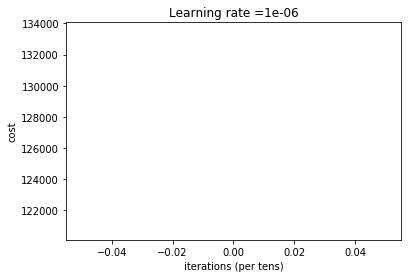

UnboundLocalError: local variable 'parameters' referenced before assignment

In [9]:

# Baseline Test Case
H = padded_proposals.astype(np.float32)
framestamps = padded_framestamps
Ipast = temporal_indicator(framestamps, mode="past")
Ipast = Ipast.astype(np.float32)
Ifuture = temporal_indicator(framestamps, mode="future")
Ifuture = Ifuture.astype(np.float32)
emb_matrix, word2id, id2word = get_wordvector(embedding_size,vocab_size,vocabulary) #changed by Songze
sentence_ids = all_padded_sentences_id
Ycaptions = copy.deepcopy(all_padded_sentences_2) # holds i
Xcaptions = copy.deepcopy(all_padded_sentences)

Xcaptions = Xcaptions.astype(np.int32)
Ycaptions = Ycaptions.astype(np.int32)

Xcaptions = np.transpose(Xcaptions,axes=(0,2,1))
Ycaptions = np.transpose(Ycaptions,axes=(0,2,1))

print(Ycaptions.dtype)

print("H.shape: ", H.shape)
print("framestamps.shape: ", framestamps.shape)
print("Ipast.shape: ", Ipast.shape)
print("Ifuture.shape: ", Ifuture.shape)
print("Ycaptions.shape: ", Ycaptions.shape)
print("Xcaptions.shape: ", Xcaptions.shape)

model(H, Ipast, Ifuture, Ycaptions, Xcaptions,len(word2id))


# Ignore Code Below for Now

In [ ]:
def add_loss(self):
       """
       Add loss computation to the graph.

       Uses:
         self.logits_start: shape (batch_size, context_len)
           IMPORTANT: Assumes that self.logits_start is masked (i.e. has -large in masked locations).
           That's because the tf.nn.sparse_softmax_cross_entropy_with_logits
           function applies softmax and then computes cross-entropy loss.
           So you need to apply masking to the logits (by subtracting large
           number in the padding location) BEFORE you pass to the
           sparse_softmax_cross_entropy_with_logits function.

         self.ans_span: shape (batch_size, 2)
           Contains the gold start and end locations

       Defines:
         self.loss_start, self.loss_end, self.loss: all scalar tensors
       """
       with vs.variable_scope("loss"):

           # Calculate loss for prediction of start position
           loss_start = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits_start, labels=self.ans_span[:, 0]) # loss_start has shape (batch_size)
           self.loss_start = tf.reduce_mean(loss_start) # scalar. avg across batch
           tf.summary.scalar('loss_start', self.loss_start) # log to tensorboard

           # Calculate loss for prediction of end position
           loss_end = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits_end, labels=self.ans_span[:, 1])
           self.loss_end = tf.reduce_mean(loss_end)
           tf.summary.scalar('loss_end', self.loss_end)

           # Add the two losses
           self.loss = self.loss_start + self.loss_end
           tf.summary.scalar('loss', self.loss)

In [ ]:
def loss(Hout,Sout,embeddings,word2id,rnn_outputs,x,y):
    state_size = 512
    batch_size = Hout.shape[0]
    num_steps = Sout[1]
    num_classes = embeddings[1]
    num_layers = 2
    initializer = Hout
    
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    #reshape rnn_outputs and y so we can get the logits in a single matmul
    rnn_outputs = tf.reshape(rnn_outputs, [-1, state_size])
    y_reshaped = tf.reshape(y, [-1])
    logits = tf.matmul(rnn_outputs, W) + b
    losses = tf.reshape(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped),[batch_size, num_steps])
    loss_by_timestep = tf.reduce_mean(losses, reduction_indices=0)


In [ ]:
def add_embedding_layer(sentence_ids,emb_matrix):
    """
    Adds word embedding layer to the graph.

    Inputs:
      emb_matrix: shape (400002, embedding_size).
      The Glove vectors, plus vectors for PAD and UNK.
    """
    #with vs.variable_scope("embeddings"):

    # Note: the embedding matrix is a tf.constant which means it's not a trainable parameter
    embedding_matrix = tf.constant(emb_matrix, dtype=tf.float32, name="emb_matrix") # shape (400002, embedding_size)

    # Get the word embeddings for the caption
    # using the placeholders caption
    #cap_embs = embedding_ops.embedding_lookup(embedding_matrix, sentence_ids) # shape (batch_size, context_len, embedding_size)
    cap_embs = tf.nn.embedding_lookup(embedding_matrix, sentence_ids)
       
    return cap_embs

In [ ]:
parameters = model(X_train, Y_train, X_test, Y_test)

# Test Data (incomplete)

In [ ]:
#train_ids = [line.strip() for line in open("id_data/train_ids.csv", 'r')]
filename = "c3d_data/sub_activitynet_v1-3.c3d.hdf5"
video_feature_representation = h5py.File(filename, 'r')
train_ids = ["v_--0edUL8zmA","v_hHiPEAiYKv0","v_u2uoYvo8J5s","v_c_NlYvL96y0","v_sJFgo9H6zNo"]
video_data = dict()
for videoid in train_ids:
    print(videoid)
    proposals_df = pd.read_csv('prop_data/' + videoid + '.csv',sep=' ')
    c3d_features = video_feature_representation[videoid]['c3d_features'].value
    max_frames = c3d_features.shape[0]
    print(max_frames)
    
    for i in range(proposals_df.shape[0]):
        f_init = proposals_df["f-init"][i]
        f_end =  proposals_df["f-end"][i]
        if (f_init < max_frames) and (f_end > 0):
            if f_init < 0:
                f_init = 0
            if f_end > max_frames:
                f_end = max_frames
        
            #print((f_init,f_end))
            #print(c3d_features[f_init:f_end,:].shape)
            h = temporal_pooling(c3d_features[f_init:f_end,:], mode="max")
            if i == 0:
                H = h
            else:
                H = np.column_stack((H,h))
        else:
            proposals_df.drop(proposals_df.index[i])
    video_data[videoid] = H
    